# 53  Automated Conformance Testing for JavaScript Engines via Deep Compiler Fuzzing: Artifact - Interactive Demo


## Preliminaries 
This interactive Jupyter notebook provides a small-scale demo for showcasing our test program generator, test case mutation, and differential tester. 

The main result of our paper is a list of bugs exposing by our tool. This list can be found at our public GitHub repository [COMFORT Github](https://github.com/NWU-NISL-Fuzzing/COMFORT/blob/main/artifact_evaluation). 

The work presented in our paper ran on a much larger dataset and for longer. For examples, the test program generator was trained on 140,000 JS programs for 30 hours on GPUs. Differential testing of JS engines was performed on 102 JS testbeds, using 250,000 synthesised JS programs, where each JS testbed ran for 200 hours on a multi-core server. 

### Instructions for Experimental Workflow: 

Before you start, please first make a copy of the notebook by going to the [landing page](http://47.241.14.25:8830/). Then select the checkbox next to the notebook titled main.ipynb, then click “Duplicate”. 

Click the name of the newly created Jupyter Notebook, e.g. main-Copy1.ipynb. Next, select "Kernel" > "Restart & Clear Output". 
Then, repeatedly press the play button (the tooltip is “run cell, select below”) to step through each cell of the notebook.

Alternatively, select each cell in turn and use “Cell” > “Run Cell” from the menu to run specific cells. Note that some cells depend on previous cells being executed. If any errors occur, ensure all previous cells have been executed.

### Important Notes

**Some cells can take a few minutes to complete; please wait for the results until step to the next cell.** 

High load can lead to a long wait for results. This may occur if multiple reviewers are simultaneously trying to generate results.

The experiments are fully customisable as the code provided in the Jupyter Notebook can be edited on the spot. Simply type your changes into the code blocks and re-run using “Cell” > “Run Cells” from the menu.

### Links to The Paper
For each step, we provide the section number of the submitted version where the relevant technique is described or data is presented. 

The main resuls - the discovered bugs are detailed at [the COMFORT Github repository](https://github.com/NWU-NISL-Fuzzing/COMFORT/blob/main/artifact_evaluation).


## Step 1. Test  Program Generation

### Step 1-1 JS program generation (Section 3.2)

Here we provide a scale-downed pre-trained GPT-2 model for JS program generation. For convenience, we have also supplied a seed text for program generation. However, you can change the configurable parameters defined in the cell. 

*Tips: Try to repeatedly run the cell to obtain a different program*. 


In [12]:
# JS Program Generation

import sys
import pathlib
sys.path.extend([str(pathlib.Path.cwd() / "src")])
import Ipynb_importer
from src.generate_model.generate import generate

print("Note that: you can configure the parameters or re-run the cell to obtain a different result.")


#You can change the following parameters, top_k, top_p, temperatur, and seed texts
#You can repeatly run this section to generate potentially different programs using the same seed text

#top_k - sample only from top k tokens
#an integer value controlling diversity. 1 means only 1 word is
#considered for each step (token), resulting in deterministic completions,
#0 (default) is a  special setting meaning no restrictions 
top_k = 0 

# Sample from the a list of model output tokens that have a probability >= top_p
# This parameter should take in values between 0 and 0.5.
# It overwrites top_k if it is set to nonzero
top_p = 0.0  

#Float value controlling randomness in boltzmann distribution. 
#Lower temperature results in less random completions. As the
#temperature approaches zero, the model will become deterministic and
#repetitive. Higher temperature results in more random completions.
#This value should set between 1.0 and 1.5. 
# A higher temperature can lead to longer but fewer synatically correct programs. 
#We use temperature = 1.0 in the paper
temperature = 1.0

#Seed input for program generation
seed = '//JavascriptTop2000Functions\nfunction() {\nvar newobj=Number(1).toString("Hello")'

print("Generating JS test program (approx 2 minutes - including model load time)...\n")
text = generate(temperature, top_p, top_k, seed)

print("\nThe generated JS program is：")
print("----------------------------------\n")
print(text)
print("----------------------------------\n")

Note that: you can configure the parameters or re-run the cell to obtain a different result.
Generating JS test program (approx 2 minutes - including model load time)...


The generated JS program is：
----------------------------------

function() {
var newobj=Number(1).toString("Hello") === "{2}";
    var prefix = "new " + newobj + prefix;
}

----------------------------------



### Step 1-2 Test Program Assembly 

We now check the generated JS program by inferring its data types to generate a calling routine to form a complete test case.  


In [13]:
# Create calling routine
from generate_model.callable_processor import CallableProcessor

print(f"Assembly test program (approx 30 seconds)...\n")
callable_processor = CallableProcessor()
testcase = callable_processor.get_self_calling(text)

print(f"Test program after creating the calling routine：\n")
print(f"----------------------------------\n")
print(testcase)

Assembly test program (approx 30 seconds)...

Test program after creating the calling routine：

----------------------------------

var NISLFuzzingFunc = function() {
var newobj=Number(1).toString("Hello") === "{2}";
    var prefix = "new " + newobj + prefix;
}
;
var NISLCallingResult = NISLFuzzingFunc();
print(NISLCallingResult);


## Step 2 Test case mutation and input data generation (Section 3.3)

### Step 2-1 Query ECMA-262 database

We now parse the test program to obtain the JS API calling routines and search our ECMA-262 database (constructed by ourselves) to mutate the program to generate further test cases.

As an output, we print out the query results from our ECMA-262 database. A query outcome contains the following data fields:
    - name: the argument name that passed to a JS API
    - type: the potential type of the argument (inferred by COMFORT)
    - conditions: the boundary values related to the inputting argument of the API
    - scopes: the scope of randomly generated argument values, according to boundary conditions defined in ECMA-262
    - values: a list of candidate argument values used in differential testing in the next step  


In [14]:
import json
from testcase_mutation.mutator import Mutator
from utils.utils import print_info

print(f"Query ECMA-262 database (approx 30 seconds)...\n")
#Test case mutator
mutator = Mutator()
#Query our ECMA-262 database
query_result = mutator.get_semantic_info(testcase)

#Print out ht equery
print_info(query_result)

Query ECMA-262 database (approx 30 seconds)...

Number.prototype.toString:
{
    "name": "radix",
    "type": "integer",
    "conditions": [
        "radix === undefined",
        "radix === undefined",
        "radix < 2",
        "radix > 36",
        "radix === 10"
    ],
    "scopes": [
        2,
        36
    ],
    "values": [
        "undefined",
        10,
        1,
        37,
        7,
        "NaN",
        0,
        "Infinity",
        "-Infinity"
    ]
}
Number:
{
    "name": "value",
    "type": "number",
    "conditions": [],
    "scopes": [],
    "values": []
}


### Step2-2 Test case mutation
Using the query information, we mutate the generated JS programs (by changing argument values) to generate multiple test cases. 

In [15]:
print(f"Test case mutation (approx 1 minute)...\n")

# Step 2-2. Test case mutation
mutator = Mutator()
testcase_list = mutator.mutate(testcase)

for i in testcase_list:
    print('=' * 50)
    print(i)

Test case mutation (approx 1 minute)...

var NISLFuzzingFunc = function (nislMutationParameter0) {
    var newobj = Number(1).toString(nislMutationParameter0) === '{2}';
    var prefix = 'new ' + newobj + prefix;
};
var nislMutationArgument0 = 37;
var NISLCallingResult = NISLFuzzingFunc(nislMutationArgument0);
print(NISLCallingResult);
var NISLFuzzingFunc = function (nislMutationParameter0) {
    var newobj = Number(nislMutationParameter0).toString('Hello') === '{2}';
    var prefix = 'new ' + newobj + prefix;
};
var nislMutationArgument0 = false;
var NISLCallingResult = NISLFuzzingFunc(nislMutationArgument0);
print(NISLCallingResult);
var NISLFuzzingFunc = function (nislMutationParameter0) {
    var newobj = Number(nislMutationParameter0).toString('Hello') === '{2}';
    var prefix = 'new ' + newobj + prefix;
};
var nislMutationArgument0 = null;
var NISLCallingResult = NISLFuzzingFunc(nislMutationArgument0);
print(NISLCallingResult);
var NISLFuzzingFunc = function (nislMutationParamet

## Step-3 Differential Testing (Section 3.4)
We now perform differential testing by running the test cases on multiple JS engines and compare the results. 

For demonstration, we terminate the process when we find a test case that required manual inspection. For our paper, we spend 200 hours on differential testing for each test JS engine. 

In [16]:
# step3. Differential Fuzzing

from detection import harness, Result


print(f"Performing differential testing (approx 2 minutes)...")

harness = harness.Harness()

harness_result = None  # The execution results of all JS engines
test_result_list = None  # A list of suspicious test results found through differential testing
for test_case in testcase_list:
    # The differential testing outputs
    harness_result = harness.run_testcase(test_case)
    
    # Inconsistent testing result list 
    test_result_list = Result.differential_test(harness_result)
    
    # The test case did not trigger any suspicious behaviour, continue
    if len(test_result_list) < 1:
        continue
        
    print(f"\nInconsistent behaviour found by differential testing:\n")
    print(f"------------------------------------------------------\n")
        
    for interesting_test_result in test_result_list:
        print(interesting_test_result)
        
    print(f"\n JS engines running results:")
    print(f"------------------------------------------------------\n")
    print(f"{harness_result}")
    break  
    
    # For the purpose of demonstration, we terminate the process when we find a test case that required manually inspection
    
if test_result_list is None or len(test_result_list) < 1:
    print("\033[1;31;48mTips: No Potential Non-Conformance Behaviors Detected, Please Restrart from Step 1\033[0m")

Performing differential testing (approx 2 minutes)...

Inconsistent behaviour found by differential testing:

------------------------------------------------------

{
    "Differential Test Result": {
        "error_type": "Majority JS engines throw runtime error/exception",
        "output_id": 7,
        "inconsistent_testbed": "/mnt/aliyun/.jsvu/jerryscript-7df87b7",
        "classify_result": null,
        "classify_id": null
    }
}

 JS engines running results:
------------------------------------------------------

{
    "Harness Result": {
        "testcase": "var NISLFuzzingFunc = function (nislMutationParameter0) {\n    var newobj = Number(nislMutationParameter0).toString('Hello') === '{2}';\n    var prefix = 'new ' + newobj + prefix;\n};\nvar nislMutationArgument0 = false;\nvar NISLCallingResult = NISLFuzzingFunc(nislMutationArgument0);\nprint(NISLCallingResult);",
        "outputs": [
            {
                "id": 0,
                "testbed": "/mnt/aliyun/.jsvu/engi

## Step 4 Test Case Reduction (Section 3.5)
We run a simple test case reduction process to minimize the interesting test cases found in differential testing before presenting them to the devloper for manual inspection. 

In [17]:
# step4. Test Case Reduction

from testcase_reducer.simplify import simplify


print("Simplifying test cases (approx. 2 minutes)...\n")
reduced_test_case = simplify(harness_result.testcase)
print(f"Original test case:")
print(f"------------------------------------------------------\n")
print(f"\n{harness_result.testcase}")
print(f"\nSimplified test case:")
print(f"------------------------------------------------------\n")
print(f"\n{reduced_test_case}")


Simplifying test cases (approx. 2 minutes)...

Original test case:
------------------------------------------------------


var NISLFuzzingFunc = function (nislMutationParameter0) {
    var newobj = Number(nislMutationParameter0).toString('Hello') === '{2}';
    var prefix = 'new ' + newobj + prefix;
};
var nislMutationArgument0 = false;
var NISLCallingResult = NISLFuzzingFunc(nislMutationArgument0);
print(NISLCallingResult);

Simplified test case:
------------------------------------------------------


var NISLFuzzingFunc = function (nislMutationParameter0) {
    var newobj = Number(nislMutationParameter0).toString('Hello') === '{2}';
};
var nislMutationArgument0 = false;
var NISLCallingResult = NISLFuzzingFunc(nislMutationArgument0);


## Step 5 Filtering Identical Test Cases (Section 3.6)

We now filter out the reduced test case using our knowledge base. The idea is we do not ask developer intervention if an identical buggy behaviour has seen before (e.g., triggered by a different test case).

This test case is likely to trigger an indentical bug seen in our previously experiment runs and hence the number cases to be manually inspected is likely to be 0. 


In [18]:
# step-5 filtering test cases

from filter.classify import Classifier

print(f"Filtering test cases (approx. 30 seconds)...\n")
classify = Classifier()  # Test case filter
# classify.clear_recorders() #Empting all the test cases

suspicious_result = classify.filter(test_result_list, harness_result)
print(f"\n#Suspicious results that need to be manually inspected after filtering is: {len(suspicious_result)}:\n")
print(f"------------------------------------------------------\n")
for interesting_test_result in suspicious_result:
    print(interesting_test_result)

Filtering test cases (approx. 30 seconds)...


#Suspicious results that need to be manually inspected after filtering is: 0:

------------------------------------------------------



## Other Results (Section 5)

A list of bugs found by our tool and the relevant bug report can be found at our public GitHub repository [COMFORT Github](https://github.com/NWU-NISL-Fuzzing/COMFORT/blob/main/artifact_evaluation). 

Here, we plot the digrams of other results using offline generated data (it would take too long to run the experiment live).
A full list of raw test cases used to plot the diagrams can be found from our public GitHub repository [COMFORT Github](https://github.com/NWU-NISL-Fuzzing/COMFORT/blob/main/artifact_evaluation). 

### Bug Statistics
The below program reproduces Figure 6 in Section 5.1 of our paper

Figure 6. #COMFORT-found bugs per compiler components:

{'CodeGen': [42, 49], 'Implementation': [41, 45], 'Parser': [13, 15], 'RegExp Engine': [8, 9], 'Strict Mode': [8, 8], 'Optimizer': [3, 3]}


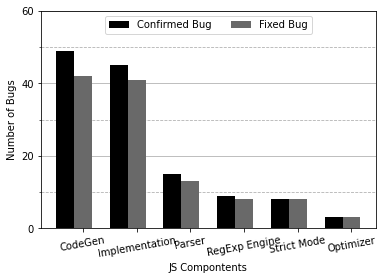

In [8]:
# The number of COMFORT-discovered bugs per JS components (Figure 6)

import Ipynb_importer
from src.data_statistics.statistic import statistic_from_bug_db
from src.data_statistics.drawPlots import drawBars

db_path = r"/mnt/aliyun/COMFORT/data/Bug_info.db"
dict = {"CodeGen": [], "Implementation": [], "Parser": [], "RegExp Engine": [], "Strict Mode": [], "Optimizer": []}
result = statistic_from_bug_db(db_path, dict)
print(f"Figure 6. #COMFORT-found bugs per compiler components:\n")
print(result)
drawBars(result)

This below program reproduces Figure 7 in Section 5.3 of our paper

The number of bugs found by different fuzzers:

{'COMFORT_info': {'Submitted': 60, 'Confirmed': 50, 'Fixed': 48}, 'DIE_info': {'Submitted': 30, 'Confirmed': 19, 'Fixed': 9}, 'Fuzzilli_info': {'Submitted': 16, 'Confirmed': 12, 'Fixed': 9}, 'Montage_info': {'Submitted': 15, 'Confirmed': 7, 'Fixed': 5}, 'DeepSmith_info': {'Submitted': 6, 'Confirmed': 6, 'Fixed': 4}, 'CodeAlchemist_info': {'Submitted': 11, 'Confirmed': 8, 'Fixed': 5}}


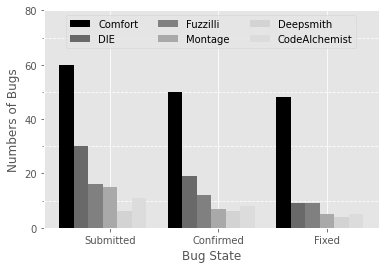

In [9]:
# The number of bugs found by different fuzzers (Figure 7)

import Ipynb_importer
from src.data_statistics.statisticsOthers import statistic
from src.data_statistics.drawPlotsOthers import drawBars

db_path = r"/mnt/aliyun/COMFORT/data/Bug_info.db"
table_name = {"COMFORT_info": [], "DIE_info":[], "Fuzzilli_info":[],"Montage_info":[],"DeepSmith_info":[], "CodeAlchemist_info":[]}
result = statistic(db_path,table_name)
print(f"The number of bugs found by different fuzzers:\n")
print(result)
drawBars(result)

### Quality of the Generated Test Cases

The below cell plots Figure 8 in Section 5.3.3 of our paper. 

*Notes*: The experiment was performed on 9,000 randomly chosen test, syntatically correct programs. As the programs are randomly chosen, the number may be slightly different from the ones presented in the paper. 

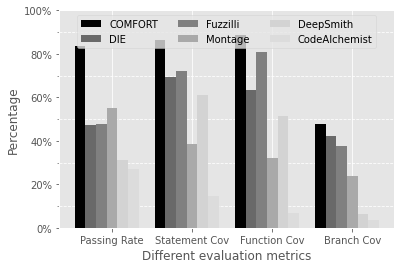

In [10]:
#This script computes the coverage of the JS programs generated by various methods using our own data

import Ipynb_importer
from src.compare_experiment.drawPlots import drawBars, extractMetrics

coverages = []
fuzzers = ["COMFORT", "DIE", "Fuzzilli", "Montage", "DeepSmith", "CodeAlchemist"]
for fuzzer in fuzzers:
    coverages.append(extractMetrics(fuzzer))
drawBars(coverages, fuzzers)